### **DGM – SABR Forward CDF**

* **We solve the forward cumulative distribution function (CDF)**
  under the SABR model using the Deep Galerkin Method (DGM), avoiding the Dirac delta initial condition in the forward PDE by working with the CDF instead.

* **The PDE we solve corresponds to the backward Kolmogorov equation**
  for the cumulative function $u(t, Y, \alpha; Y_T, \alpha_T, \rho, \beta) = \mathbb{P}(Y_T > Y, \alpha_T > \alpha)$, where $Y$ is the forward price and $\alpha$ is the instantaneous volatility.

* **The PDE reads:**

  \begin{align*}
  \frac{\partial u}{\partial t}
  + \frac{1}{2} \alpha^2 Y^{2\beta} \frac{\partial^2 u}{\partial Y^2}
  + \rho \alpha Y^\beta \frac{\partial^2 u}{\partial Y \partial \alpha}
  + \frac{1}{2} \frac{\partial^2 u}{\partial \alpha^2}
  - \frac{1}{2} \frac{\partial u}{\partial \alpha} = 0
  \end{align*}

* **Terminal condition at $t = T$:**

  \begin{align*}
  u(T, Y, \alpha; Y_T, \alpha_T, \rho, \beta) = \mathbf{1}_{\{Y_T > Y,\, \alpha_T > \alpha\}}
  \end{align*}

* **Boundary condition at $Y = 0$:**

  \begin{align*}
  u(t, 0, \alpha; Y_T, \alpha_T, \rho, \beta) = 0
  \end{align*}

  This is justified because the diffusion term $\alpha^2 Y^{2\beta}$ vanishes as $Y \to 0$,
  making it an absorbing boundary. Financially, once the forward price reaches zero,
  the probability of it exceeding any positive $Y_T$ becomes negligible.

* **Network inputs include:**
  $t, Y, \alpha, Y_T, \alpha_T, \rho, \beta$
  (6-dimensional parametric PDE setting)

* **The loss function includes:**

  * PDE residual across the interior domain
  * Boundary loss at $Y = 0$
  * Terminal mismatch between predicted CDF and indicator function at $t = T$

* **After training**, the CDF can be differentiated w\.r.t. $Y_T$ or $\alpha_T$
  to obtain the joint or marginal transition densities.


In [ ]:
import time, pathlib, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.autograd import grad

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# domain limits
T_FINAL = 1.2
Y0_LOW,  Y0_HIGH  = 0.0 , 5.0
A0_LOW,  A0_HIGH  = 0.01, 1.0
YT_LOW,  YT_HIGH  = 0.0 , 5.0
AT_LOW,  AT_HIGH  = 0.0001, 3.0
RHO_LOW, RHO_HIGH = -1.0, 0.0
BETA_LOW,BETA_HIGH= 0.5 , 1.0
NU_LOW,  NU_HIGH  = 0.1 , 1.0

BATCH_PDE, BATCH_BDRY, BATCH_TERM = 16384, 2048, 8192
STEPS_PER_SAMPLE = 1
SAMPLING_STAGES  = 30000
L_PDE, L_BDRY, L_TERM = 1, 1, 1

# DGM network
defining_dim = 1 + 7  # t plus [Y, a, YT, aT, rho, beta, nu]
class DGMBlock(nn.Module):
    def __init__(self, din, dh):
        super().__init__()
        self.Uz, self.Wz = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
        self.Ug, self.Wg = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
        self.Ur, self.Wr = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
        self.Uh, self.Wh = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
    def forward(self,x,h):
        z = torch.sigmoid(self.Uz(x)+self.Wz(h))
        g = torch.sigmoid(self.Ug(x)+self.Wg(h))
        r = torch.sigmoid(self.Ur(x)+self.Wr(h))
        h_ = torch.tanh(self.Uh(x)+self.Wh(r*h))
        return (1-g)*h + g*h_

class DGMNet(nn.Module):
    def __init__(self, hidden=64, layers=3):
        super().__init__()
        self.inp   = nn.Linear(defining_dim, hidden)
        self.blocks= nn.ModuleList([DGMBlock(defining_dim, hidden) for _ in range(layers)])
        self.out   = nn.Linear(hidden, 1)
    def forward(self, t, x):
        z = torch.cat([t, x], dim=1)
        h = torch.tanh(self.inp(z))
        for blk in self.blocks:
            h = blk(z, h)
        return self.out(h)

# sampler
def sampler(n1: int, n2: int, n3: int):
    # PDE interior
    t1  = torch.rand(n1, 1, device=DEVICE) * T_FINAL
    Y1  = torch.rand(n1, 1, device=DEVICE) * (Y0_HIGH - Y0_LOW) + Y0_LOW
    a1  = torch.rand(n1, 1, device=DEVICE) * (A0_HIGH - A0_LOW) + A0_LOW
    YT1 = torch.rand(n1, 1, device=DEVICE) * (YT_HIGH - YT_LOW) + YT_LOW
    aT1 = torch.rand(n1, 1, device=DEVICE) * (AT_HIGH - AT_LOW) + AT_LOW
    rho1  = torch.rand(n1, 1, device=DEVICE) * (RHO_HIGH - RHO_LOW) + RHO_LOW
    beta1 = torch.rand(n1, 1, device=DEVICE) * (BETA_HIGH - BETA_LOW) + BETA_LOW
    nu1   = torch.rand(n1, 1, device=DEVICE) * (NU_HIGH - NU_LOW) + NU_LOW

    # boundary Y=0
    t2  = torch.rand(n2, 1, device=DEVICE) * T_FINAL
    Y2  = torch.zeros(n2, 1, device=DEVICE)
    a2  = torch.rand(n2, 1, device=DEVICE) * (A0_HIGH - A0_LOW) + A0_LOW
    YT2 = torch.rand(n2, 1, device=DEVICE) * (YT_HIGH - YT_LOW) + YT_LOW
    aT2 = torch.rand(n2, 1, device=DEVICE) * (AT_HIGH - AT_LOW) + AT_LOW
    rho2  = torch.rand(n2, 1, device=DEVICE) * (RHO_HIGH - RHO_LOW) + RHO_LOW
    beta2 = torch.rand(n2, 1, device=DEVICE) * (BETA_HIGH - BETA_LOW) + BETA_LOW
    nu2   = torch.rand(n2, 1, device=DEVICE) * (NU_HIGH - NU_LOW) + NU_LOW

    # terminal t = T
    t3  = T_FINAL * torch.ones(n3, 1, device=DEVICE)
    Y3  = torch.rand(n3, 1, device=DEVICE) * (Y0_HIGH - Y0_LOW) + Y0_LOW
    a3  = torch.rand(n3, 1, device=DEVICE) * (A0_HIGH - A0_LOW) + A0_LOW
    YT3 = torch.rand(n3, 1, device=DEVICE) * (YT_HIGH - YT_LOW) + YT_LOW
    aT3 = torch.rand(n3, 1, device=DEVICE) * (AT_HIGH - AT_LOW) + AT_LOW
    rho3  = torch.rand(n3, 1, device=DEVICE) * (RHO_HIGH - RHO_LOW) + RHO_LOW
    beta3 = torch.rand(n3, 1, device=DEVICE) * (BETA_HIGH - BETA_LOW) + BETA_LOW
    nu3   = torch.rand(n3, 1, device=DEVICE) * (NU_HIGH - NU_LOW) + NU_LOW

    return (t1, Y1, a1, YT1, aT1, rho1, beta1, nu1,
            t2, Y2, a2, YT2, aT2, rho2, beta2, nu2,
            t3, Y3, a3, YT3, aT3, rho3, beta3, nu3)

# loss
def loss_fn(mdl,
            t1, Y1, a1, YT1, aT1, rho1, beta1, nu1,
            t2, Y2, a2, YT2, aT2, rho2, beta2, nu2,
            t3, Y3, a3, YT3, aT3, rho3, beta3, nu3):

    x1  = torch.cat([Y1, a1, YT1, aT1, rho1, beta1, nu1], dim=1).detach().clone().requires_grad_(True)
    t1r = t1.detach().clone().requires_grad_(True)
    V   = mdl(t1r, x1)

    V_t = grad(V, t1r, torch.ones_like(V), create_graph=True)[0]
    g   = grad(V, x1, torch.ones_like(V), create_graph=True)[0]
    V_Y, V_a = g[:,0:1], g[:,1:2]
    V_YY = grad(V_Y, x1, torch.ones_like(V_Y), create_graph=True)[0][:,0:1]
    V_aa = grad(V_a, x1, torch.ones_like(V_a), create_graph=True)[0][:,1:2]
    V_Ya = grad(V_Y, x1, torch.ones_like(V_Y), create_graph=True)[0][:,1:2]

    f = (V_t
         + 0.5 * a1**2 * Y1**(2*beta1) * V_YY
         + 0.5 * (nu1**2) * a1**2 * V_aa
         + rho1 * nu1 * a1**2 * Y1**beta1 * V_Ya)

    L1 = (f**2).mean()

    # Y=0 boundary condition
    V_bdry = mdl(t2, torch.cat([Y2, a2, YT2, aT2, rho2, beta2, nu2], dim=1))
    L2 = (V_bdry**2).mean()

    # terminal payoff
    payoff = ((YT3 > Y3) & (aT3 > a3)).float()
    V_T = mdl(t3, torch.cat([Y3, a3, YT3, aT3, rho3, beta3, nu3], dim=1))
    L3 = ((V_T - payoff)**2).mean()

    return L1, L2, L3

# training
LR = 1e-3
model = DGMNet().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.90)
print("Start training …")
start = time.perf_counter()

for stage in range(1, SAMPLING_STAGES + 1):
    batch = sampler(BATCH_PDE, BATCH_BDRY, BATCH_TERM)
    for _ in range(STEPS_PER_SAMPLE):
        opt.zero_grad()
        L1, L2, L3 = loss_fn(model, *batch)
        loss_tot = L_PDE * L1 + L_BDRY * L2 + L_TERM * L3
        loss_tot.backward()
        opt.step()
    if stage % 2000 == 0:
        scheduler.step()
    if stage % 200 == 0:
        cur_lr = scheduler.get_last_lr()[0]
        dt = time.perf_counter() - start
        print(f"stage {stage:05d} | tot {loss_tot.item():.2e} | "
              f"L1 {L1.item():.2e} | L2 {L2.item():.2e} | L3 {L3.item():.2e} | "
              f"lr {cur_lr:.2e} | {dt/stage:.3f}s/ep")

# save
pathlib.Path("Results/SABR_price_noLog").mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), "Results/SABR_price_noLog/dgm_sabr_cdf.pth")
print("Weights saved to Results/SABR_price_noLog/dgm_sabr_cdf.pth")


Device: cuda
Start training …
stage 00200 | tot 7.84e-02 | L1 5.43e-03 | L2 2.43e-03 | L3 7.06e-02 | lr 1.00e-03 | 0.060s/ep
stage 00400 | tot 4.58e-02 | L1 6.10e-03 | L2 1.39e-03 | L3 3.83e-02 | lr 1.00e-03 | 0.060s/ep
stage 00600 | tot 3.78e-02 | L1 5.04e-03 | L2 3.03e-03 | L3 2.97e-02 | lr 1.00e-03 | 0.060s/ep
stage 00800 | tot 3.10e-02 | L1 4.73e-03 | L2 6.01e-04 | L3 2.57e-02 | lr 1.00e-03 | 0.060s/ep
stage 01000 | tot 2.85e-02 | L1 4.43e-03 | L2 5.60e-04 | L3 2.35e-02 | lr 1.00e-03 | 0.059s/ep
stage 01200 | tot 2.67e-02 | L1 4.62e-03 | L2 1.12e-03 | L3 2.09e-02 | lr 1.00e-03 | 0.059s/ep
stage 01400 | tot 2.58e-02 | L1 4.12e-03 | L2 1.27e-03 | L3 2.04e-02 | lr 1.00e-03 | 0.059s/ep
stage 01600 | tot 2.30e-02 | L1 3.55e-03 | L2 4.18e-04 | L3 1.90e-02 | lr 1.00e-03 | 0.060s/ep
stage 01800 | tot 2.25e-02 | L1 3.51e-03 | L2 2.23e-03 | L3 1.68e-02 | lr 1.00e-03 | 0.059s/ep
stage 02000 | tot 1.92e-02 | L1 3.30e-03 | L2 3.69e-04 | L3 1.55e-02 | lr 9.00e-04 | 0.060s/ep
stage 02200 | tot 1.

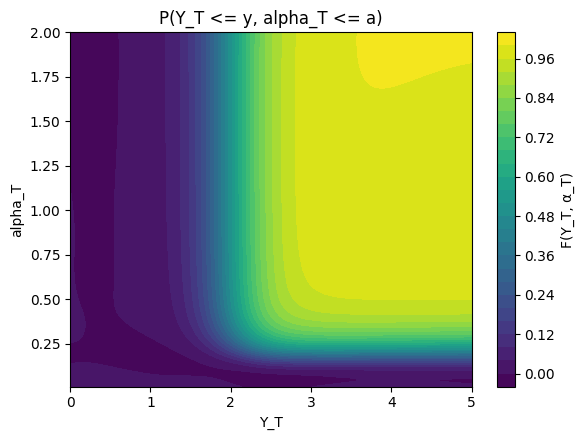

In [ ]:
# Plot CDF
import torch, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time, pathlib, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.autograd import grad
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
defining_dim = 1 + 7  # t plus [Y, a, YT, aT, rho, beta, nu]
class DGMBlock(nn.Module):
    def __init__(self, din, dh):
        super().__init__()
        self.Uz, self.Wz = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
        self.Ug, self.Wg = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
        self.Ur, self.Wr = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
        self.Uh, self.Wh = nn.Linear(din,dh), nn.Linear(dh,dh,bias=False)
    def forward(self,x,h):
        z = torch.sigmoid(self.Uz(x)+self.Wz(h))
        g = torch.sigmoid(self.Ug(x)+self.Wg(h))
        r = torch.sigmoid(self.Ur(x)+self.Wr(h))
        h_ = torch.tanh(self.Uh(x)+self.Wh(r*h))
        return (1-g)*h + g*h_

class DGMNet(nn.Module):
    def __init__(self, hidden=64, layers=3):
        super().__init__()
        self.inp   = nn.Linear(defining_dim, hidden)
        self.blocks= nn.ModuleList([DGMBlock(defining_dim, hidden) for _ in range(layers)])
        self.out   = nn.Linear(hidden, 1)
    def forward(self, t, x):
        z = torch.cat([t, x], dim=1)
        h = torch.tanh(self.inp(z))
        for blk in self.blocks:
            h = blk(z, h)
        return self.out(h)
net = DGMNet().to(DEVICE)
net.load_state_dict(torch.load(
        "dgm_sabr_cdf.pth", map_location=DEVICE))
net.eval()

t0     = 0.0
Y0, a0 = 2.0, 0.25
rho, beta, nu0 = -0.3, 0.7, 0.4

Y_grid = np.linspace(0.0, 5.0, 201, dtype=np.float32)
a_grid = np.linspace(0.01, 2.0, 201, dtype=np.float32)
YY, AA = np.meshgrid(Y_grid, a_grid, indexing="ij")

t = torch.full((YY.size,1), t0, device=DEVICE)
x = torch.tensor(
    np.column_stack([
        np.full_like(YY.ravel(), Y0),
        np.full_like(AA.ravel(), a0),
        YY.ravel(), AA.ravel(),
        np.full_like(YY.ravel(), rho),
        np.full_like(YY.ravel(), beta),
        np.full_like(YY.ravel(), nu0),
    ]),
    device=DEVICE)

with torch.no_grad():
    F = net(t, x).cpu().numpy().reshape(YY.shape)


fig, ax = plt.subplots(figsize=(6, 4.5))

cs = ax.contourf(YY, AA, F, levels=25)
fig.colorbar(cs, label="F(Y_T, α_T)")

ax.set_xlabel("Y_T")
ax.set_ylabel("alpha_T")
ax.set_title("P(Y_T <= y, alpha_T <= a)")

plt.tight_layout()
plt.show()


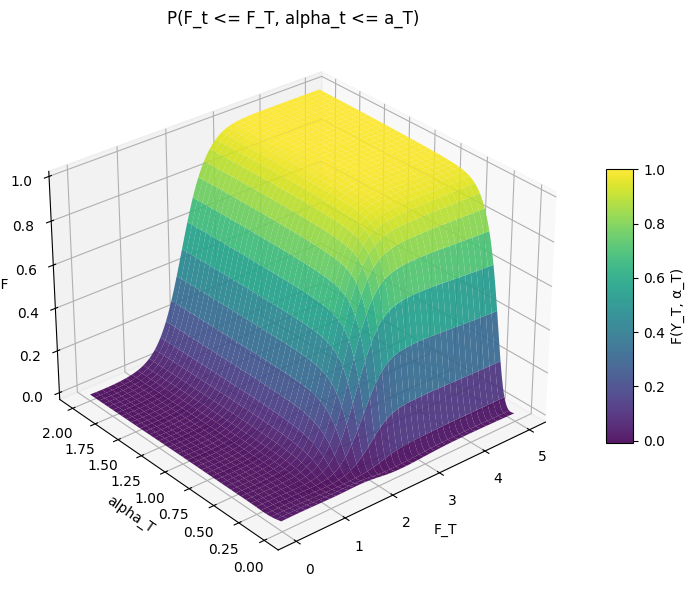

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(YY, AA, F, cmap=cm.viridis, edgecolor='none', alpha=0.9)

fig.colorbar(surf, shrink=0.5, aspect=10, label="F(Y_T, α_T)")

ax.set_xlabel("F_T")
ax.set_ylabel("alpha_T")
ax.set_zlabel("CDF")
ax.set_title("P(F_t <= F_T, alpha_t <= a_T)")
ax.view_init(elev=30, azim=230)
plt.tight_layout()
plt.show()

In [ ]:
T_FINAL = 1.2

def plot_joint_pdf_forward_time(t_fwd, Y_now, a_now,
                                rho_now=-0.3, beta_now=0.7, nu_now=0.4,
                                Y_MAX=5.0, A_MAX=2.0,
                                n_y=101, n_a=101):
    t_net = T_FINAL - t_fwd
    if not (0 <= t_net <= T_FINAL):
        raise ValueError(f"t_fwd must be in [0, {T_FINAL}]")

    t0   = torch.full((1,1), t_net, device=DEVICE)
    Y0   = torch.tensor([[Y_now]], device=DEVICE)
    a0   = torch.tensor([[a_now]], device=DEVICE)
    rho  = torch.tensor([[rho_now]], device=DEVICE)
    beta = torch.tensor([[beta_now]], device=DEVICE)
    nu   = torch.tensor([[nu_now]], device=DEVICE)

    y_grid = np.linspace(0.0, Y_MAX, n_y, dtype=np.float32)
    a_grid = np.linspace(0.0001, A_MAX, n_a, dtype=np.float32)
    YY, AA = np.meshgrid(y_grid, a_grid, indexing="ij")

    yT = torch.from_numpy(YY.ravel()).view(-1,1).to(DEVICE).requires_grad_(True)
    aT = torch.from_numpy(AA.ravel()).view(-1,1).to(DEVICE).requires_grad_(True)

    in_vec = torch.cat([
        Y0.expand_as(yT),  a0.expand_as(yT),
        yT,                aT,
        rho.expand_as(yT), beta.expand_as(yT),
        nu.expand_as(yT)
    ], dim=1)

    F  = net(t0.expand_as(yT), in_vec)
    Fy = torch.autograd.grad(F, yT, torch.ones_like(F),
                             create_graph=True, retain_graph=True)[0]
    pdf = torch.autograd.grad(Fy, aT, torch.ones_like(Fy))[0] \
              .detach().cpu().numpy().reshape(n_y, n_a)
    pdf[pdf < 0] = 0.0

    fig = plt.figure(figsize=(7,5))
    ax  = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(YY, AA, pdf, cmap="viridis",
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.6, aspect=12, label="Density")

    ax.set_xlabel("Future Price F_T")
    ax.set_ylabel("Alpha_T")
    ax.set_zlabel("Density")
    ax.set_title(
        f"DGM-SABR Fokker Planck (t = {t_fwd:.2f}, "
        f"F_T={Y_now:.2f}, a_T={a_now:.2f}, ν={nu_now:.2f})"
    )
    plt.tight_layout()
    ax.set_zlim(0, 50)
    plt.show()


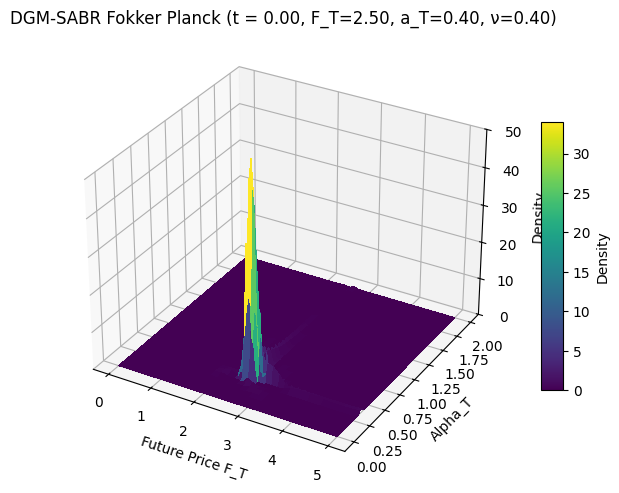

In [ ]:
plot_joint_pdf_forward_time(t_fwd=0.0, Y_now=2.5, a_now=0.4)

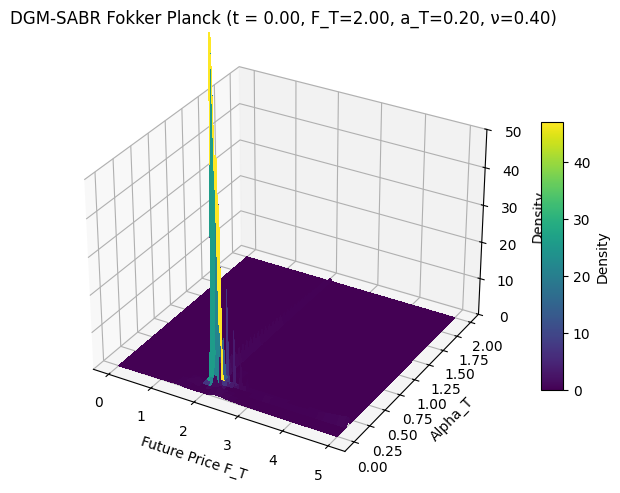

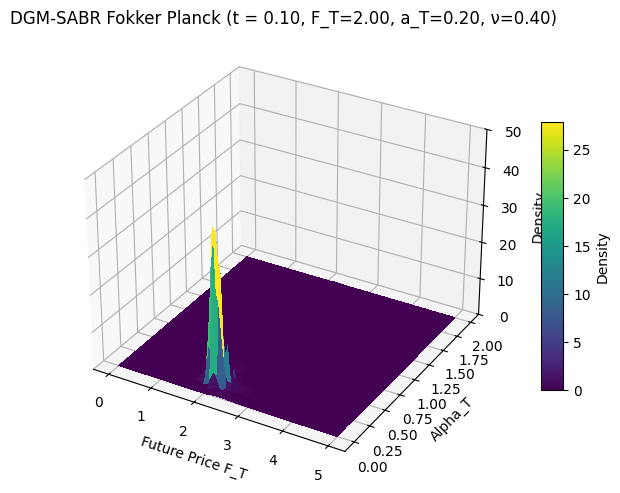

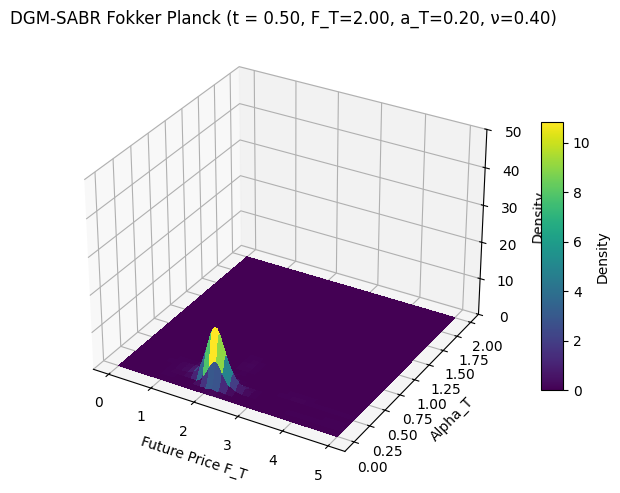

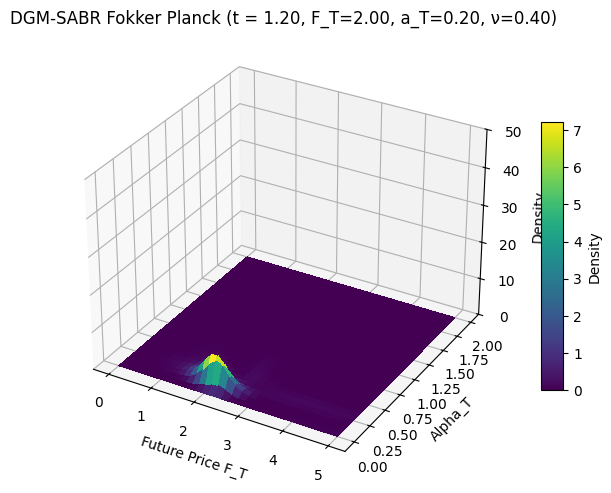

In [ ]:
for t in [0.0, 0.1, 0.5, 1.2]:
    plot_joint_pdf_forward_time(t_fwd=t, Y_now=2.0, a_now=0.2)


In [ ]:
import numpy as np
# MC Sampler
def mc_sabr_joint_density(F0=2.0, alpha0=0.4,
                          beta=0.7, rho=-0.3, nu=0.4,
                          T=1.2, dt=1/504,
                          n_paths=50000,
                          t_list=None,
                          F_edges=None, A_edges=None):

    if t_list is None:
        t_early = np.array([0.01,0.015,0.02,0.025,0.03,0.035,0.04], dtype=np.float32)
        t_main  = np.round(np.linspace(0.05, T, 30), 3)
        t_list  = np.unique(np.concatenate([t_early, t_main]))


    n_steps = int(T / dt) + 1
    times   = np.linspace(0.0, T, n_steps, dtype=np.float32)
    idx_list = [np.abs(times - t).argmin() for t in t_list]

    rng     = np.random.default_rng(20250701)
    Z1      = rng.standard_normal((n_paths, n_steps-1), dtype=np.float32)
    Z2      = rng.standard_normal((n_paths, n_steps-1), dtype=np.float32)
    sqrt_dt = np.sqrt(dt, dtype=np.float32)
    dW1     = Z1 * sqrt_dt
    dW2     = (rho * Z1 + np.sqrt(1 - rho**2, dtype=np.float32) * Z2) * sqrt_dt

    F_cur     = np.full(n_paths, F0,     dtype=np.float32)
    alpha_cur = np.full(n_paths, alpha0, dtype=np.float32)

    slices_F     = np.empty((len(t_list), n_paths), dtype=np.float32)
    slices_alpha = np.empty_like(slices_F)

    if 0 in idx_list:
        j0 = idx_list.index(0)
        slices_F[j0]     = F_cur
        slices_alpha[j0] = alpha_cur

    for k in range(1, n_steps):
        alpha_cur *= np.exp(nu * dW2[:, k-1] - 0.5*nu**2*dt)
        F_cur += alpha_cur * np.power(np.maximum(F_cur, 1e-8), beta) * dW1[:, k-1]

        if k in idx_list:
            j = idx_list.index(k)
            slices_F[j]     = F_cur
            slices_alpha[j] = alpha_cur

    joint_density = np.empty((len(t_list),
                              len(F_edges)-1,
                              len(A_edges)-1),
                             dtype=np.float32)
    for i in range(len(t_list)):
        hist, _, _ = np.histogram2d(
            slices_F[i], slices_alpha[i],
            bins=[F_edges, A_edges],
            density=True
        )
        joint_density[i] = hist

    return t_list, joint_density


In [ ]:
F_edges = np.linspace(0,6,61)
A_edges = np.linspace(0,2,41)
t_list, jd_nu04 = mc_sabr_joint_density(nu=0.4, F_edges=F_edges, A_edges=A_edges)

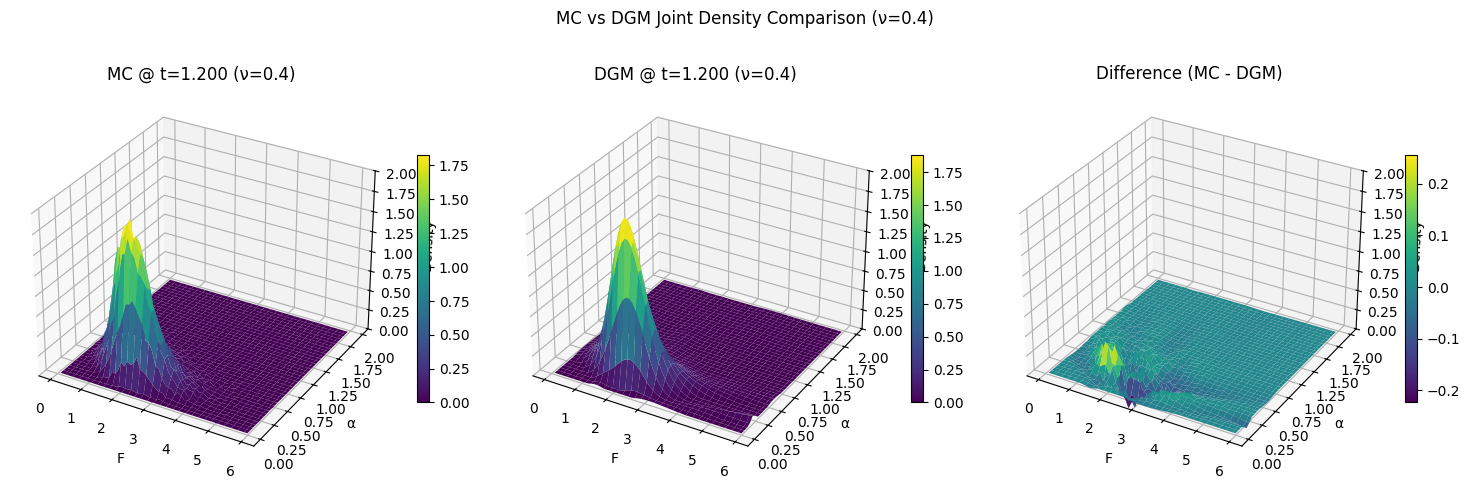

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

F_edges = np.linspace(0, 6, 61)
A_edges = np.linspace(0, 2, 41)
t_list, mc_joint = mc_sabr_joint_density(
    nu=0.4,
    F_edges=F_edges,
    A_edges=A_edges
)
F_centers = 0.5 * (F_edges[:-1] + F_edges[1:])
A_centers = 0.5 * (A_edges[:-1] + A_edges[1:])

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
net = DGMNet().to(DEVICE)
net.load_state_dict(torch.load(
    "Results/SABR_price_noLog/dgm_sabr_cdf.pth",
    map_location=DEVICE
))
net.eval()

i     = -1
t_fwd = t_list[i]
YY, AA = np.meshgrid(F_centers, A_centers, indexing="ij")

yT = torch.from_numpy(YY.ravel().astype(np.float32)) \
          .view(-1,1).to(DEVICE).requires_grad_(True)
aT = torch.from_numpy(AA.ravel().astype(np.float32)) \
          .view(-1,1).to(DEVICE).requires_grad_(True)

t0 = torch.full((1,1), t_net, dtype=torch.float32, device=DEVICE)

F0, alpha0, rho, beta, nu = 2.0, 0.4, -0.3, 0.7, 0.4
inp = torch.cat([
    torch.full_like(yT, F0),
    torch.full_like(yT, alpha0),
    yT, aT,
    torch.full_like(yT, rho),
    torch.full_like(yT, beta),
    torch.full_like(yT, nu)
], dim=1)

F_cdf  = net(t0.expand_as(yT), inp)
F_y    = torch.autograd.grad(F_cdf, yT, torch.ones_like(F_cdf),
                              create_graph=True, retain_graph=True)[0]
pdf_net = torch.autograd.grad(F_y, aT, torch.ones_like(F_y))[0] \
              .detach().cpu().numpy().reshape(YY.shape)
pdf_net[pdf_net < 0] = 0

mc_pdf = mc_joint[i]

fig = plt.figure(figsize=(15, 5))
titles = [f"MC @ t={t_fwd:.3f} (ν=0.4)",
          f"DGM @ t={t_fwd:.3f} (ν=0.4)",
          "Difference (MC - DGM)"]
datas  = [mc_pdf, pdf_net, mc_pdf - pdf_net]

for idx, (Z, ttl) in enumerate(zip(datas, titles), start=1):
    ax = fig.add_subplot(1, 3, idx, projection='3d')
    surf = ax.plot_surface(YY, AA, Z, cmap="viridis", linewidth=0)
    ax.set_xlabel("F")
    ax.set_ylabel("α")
    ax.set_zlabel("Density")
    ax.set_zlim(0, 2)
    ax.set_title(ttl)
    fig.colorbar(surf, ax=ax, shrink=0.6)

plt.suptitle("MC vs DGM Joint Density Comparison (ν=0.4)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
